# independence analysis based on product

In [1]:
import ga_utils as g
import pandas as pd
import auth as auth
import matplotlib
from ggplot import *
import config as config
%matplotlib inline

In [2]:
# ggplot required if products have special characters.
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [3]:
# launch auth process
auth.main()

In [4]:
g.list_accounts()

,id,name
0,12669588,www.felixaverlant.com
1,21801758,www.warnerbros.fr
2,33926345,Testing
3,36750385,Last Metro
4,56306116,warnerbros


In [5]:
g.list_properties(config.property)

,accountId,id,name
0,56306116,UA-56306116-1,dev.warnerbros.fr
1,56306116,UA-56306116-2,preprod.warnerbros.fr
2,56306116,UA-56306116-3,warnerbros
3,56306116,UA-56306116-4,preprod newsroom.warnerbros.fr
4,56306116,UA-56306116-5,prod Newsroom


In [6]:
g.list_profiles(config.property,config.ua)

,accountId,id,name
0,56306116,94275425,All Web Site Data
1,56306116,102852585,account.warnerbros.fr
2,56306116,102854865,www.warnerbros.fr
3,56306116,103773786,Player
4,56306116,117117062,Batman v Superman


In [7]:
df = g.get_transactions(config.profile_id, start_date='2016-01-01', end_date='2016-05-20')

In [8]:
df['count'] = 1
left = df.set_index('ga:transactionId')
right = left
df_product_comb = left.join(right, lsuffix='_l', rsuffix='_r')
df_product_comb_filtered = df_product_comb[df_product_comb['ga:productName_l'] < df_product_comb['ga:productName_r']]

In [9]:
product_cluster = df_product_comb_filtered.groupby([df_product_comb_filtered['ga:productName_l'], df_product_comb_filtered['ga:productName_r']]).sum()
product_cluster = product_cluster.drop('count_r', axis=1)
product_cluster = product_cluster.reset_index()

In [10]:
# Check if ok. Should be same number
df_product_comb['count_l'].sum()
product_cluster['count_l'].sum()

239

In [11]:
transactions_by_product = df.groupby(['ga:productName']).sum()
transactions_by_product.columns = ['transactions']
transactions_by_product

,transactions
ga:productName,
Cabal,1
La Femme Rêvée,1
Les poupées du Diable,1
Studio Tour - Ticket Adulte,685
Studio Tour - Ticket Bébé,4
Studio Tour - Ticket Enfant,5
Studio Tour - Ticket Famille,101
Studio Tour - Ticket Jeune,202


In [12]:
total_transactions = pd.to_numeric(df['count']).sum()
total_transactions

1000

In [13]:
pc = product_cluster.join(transactions_by_product['transactions'], how='left', on='ga:productName_l', rsuffix='_tot')
pc = pc.join(transactions_by_product['transactions'], how='left', on='ga:productName_r', rsuffix='_r')

In [14]:
pc['p_achat_l'] = pc['transactions'] / total_transactions
pc['p_achat_r'] = pc['transactions_r'] / total_transactions
pc['p_r_x_l'] = pc['p_achat_l'] * pc['p_achat_r']
pc['prob_observed'] = pc['count_l'] / total_transactions
pc['lift'] = pc['prob_observed'] / pc['p_r_x_l']

In [15]:
pc.sort_values(by='lift', ascending=False)

,ga:productName_l,ga:productName_r,count_l,transactions,transactions_r,p_achat_l,p_achat_r,p_r_x_l,prob_observed,lift
6,Studio Tour - Ticket Enfant,Studio Tour - Ticket Famille,2,5,101,0.005,0.101,0.000505,0.002,3.960396
4,Studio Tour - Ticket Bébé,Studio Tour - Ticket Famille,1,4,101,0.004,0.101,0.000404,0.001,2.475248
5,Studio Tour - Ticket Bébé,Studio Tour - Ticket Jeune,2,4,202,0.004,0.202,0.000808,0.002,2.475248
7,Studio Tour - Ticket Enfant,Studio Tour - Ticket Jeune,2,5,202,0.005,0.202,0.001010,0.002,1.980198
3,Studio Tour - Ticket Adulte,Studio Tour - Ticket Jeune,194,685,202,0.685,0.202,0.138370,0.194,1.402038
1,Studio Tour - Ticket Adulte,Studio Tour - Ticket Enfant,4,685,5,0.685,0.005,0.003425,0.004,1.167883
0,Studio Tour - Ticket Adulte,Studio Tour - Ticket Bébé,3,685,4,0.685,0.004,0.002740,0.003,1.094891
8,Studio Tour - Ticket Famille,Studio Tour - Ticket Jeune,13,101,202,0.101,0.202,0.020402,0.013,0.637192
2,Studio Tour - Ticket Adulte,Studio Tour - Ticket Famille,18,685,101,0.685,0.101,0.069185,0.018,0.260172


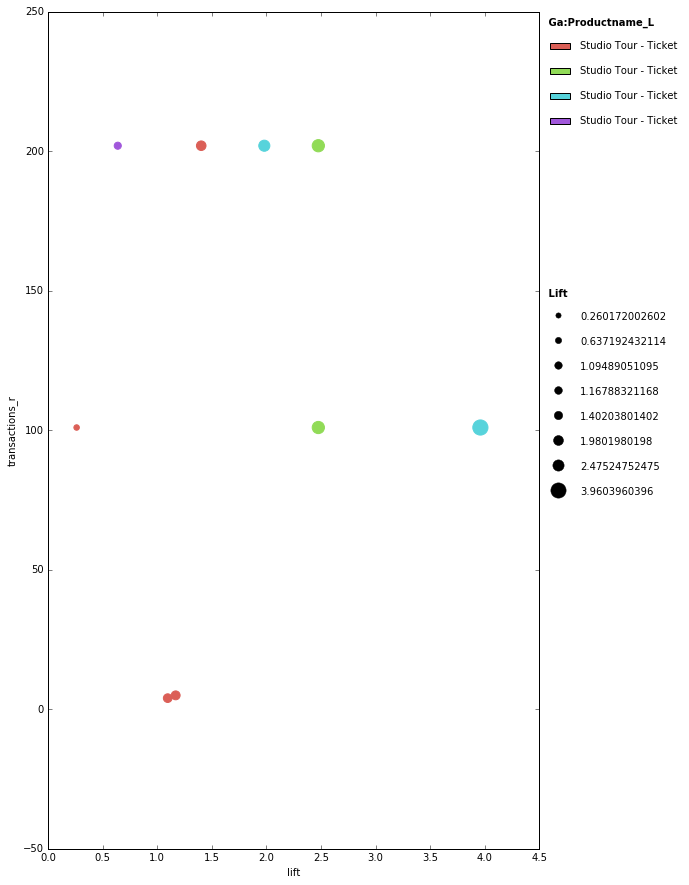

<ggplot: (299940081)>

In [19]:
ggplot(aes(x='lift', y='transactions_r', colour='ga:productName_l', size='lift'), data=pc) + geom_point() + theme_matplotlib(rc={"figure.figsize": "11,15", "legend.loc": "lower center"}, matplotlib_defaults=False)

In [20]:
from IPython.display import Javascript
Javascript("""
           window.pc={};
           """.format(pc.to_json()))

<IPython.core.display.Javascript object>

In [21]:
%%javascript

/*
 * As it turns out, pandas returns a dictionary with 
 * the top-level keys as the column headers, and values
 * as the list of values under that column.
 * I'd recommend looking yourself.
 * This function, in JS, converts to what D3 wants.
 * Of course we could also easily do this on the python side.
 */
function convertData(data){
  var convertedData = [];
  //pandas gives each column the same number of
  //objects, arbitrarily choose one to iterate over
  for(var i in data[Object.keys(data)[0]]){
    var convertedDatum = {};
    for(var key in data){
      convertedDatum[key] = data[key][i];
    }
    convertedData.push(convertedDatum);
  }
  return convertedData;
}

window.convertData = convertData;

<IPython.core.display.Javascript object>

In [22]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

In [122]:
%%javascript
require(['d3'], function(d3){
  var graph = convertData(window.pc);

  $("#chart1").remove();
  element.append("<div id='chart1'></div>");
  $("#chart1").width("960px");
  $("#chart1").height("600px");
      

  var margin = {top: 20, right: 20, bottom: 30, left: 40};
  var width = 880 - margin.left - margin.right;
  var height = 500 - margin.top - margin.bottom;
  var svg = d3.select("#chart1").append("svg")
    .style("position", "relative")
    .style("max-width", "960px")
    .attr("width", width + "px")
    .attr("height", (height + 50) + "px");

    
  var data = {};  
    
  function unique(list) {
    var result = [];
    $.each(list, function(i, e) {
        if ($.inArray(e, result) == -1) result.push(e);
    });
    return result;
}

  var n = [];
  var n2 = [];
  var lt = [];
    
  var graph_u = function() { 
      for(var i in graph){ 
          n.push(graph[i]['ga:productName_l']) 
          n.push(graph[i]['ga:productName_r'])
      }
      return unique(n)
  }()
  
  
  var nodes = function(){ 
      for(var i in graph_u){ 
          n2.push({"group":parseInt(i), "product":graph_u[i]})  
      }
      return n2
  }()
  
  data.nodes = nodes;

  function get_group(product_name){
       for(var f in nodes){
           if(nodes[f].product == product_name){
               return parseInt(nodes[f].group)
           }
       }
   }
    
    var l = [];
    for(var g in graph){
        l.push(
            {"source": get_group(graph[g]['ga:productName_l']), "target": get_group(graph[g]['ga:productName_r']), "value": graph[g]['lift']}
        )

    }

  data.links = l;
  console.log(data)
    
  var color = d3.scale.category20();

  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);
     
  force
      .nodes(data.nodes)
      .links(data.links)
      .start();

  var link = svg.selectAll(".link")
      .data(data.links)
    .enter().append("line")
      .attr("class", "link")
      .style("stroke-width", function(d) { return Math.sqrt(d.value) *2 });

  var node = svg.selectAll(".node")
      .data(data.nodes)
    .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)
      .style("fill", function(d) { return color(d.product); })
      .call(force.drag);

  node.append("title")
      .attr("dx", 12)
      .attr("dy", ".35em")
      .attr('color', "black")
      .text(function(d) { return d.product; });

  force.on("tick", function() {
    link.attr("x1", function(d) { return d.source.x; })
        .attr("y1", function(d) { return d.source.y; })
        .attr("x2", function(d) { return d.target.x; })
        .attr("y2", function(d) { return d.target.y; });

    node.attr("cx", function(d) { return d.x; })
        .attr("cy", function(d) { return d.y; });
  });
  $('.node').css('stroke', "#fff")
  $('.node').css('stroke-width','1.5')   
  $('.link').css('stroke', '#999')
  $('.link').css('stroke-opacity', '0.6')
  

  
});

<IPython.core.display.Javascript object>